# Weighting MC events when training ML algorithms

- a review of the main considerations in weighting MC events
- discuss different weighting strategies on **discovery significance** in binary classification
     - using dataset from **Kaggle Higgs ML challenge** in 2014 to demo 
     - this is just a demo, not conclusive proof of the best weighting strategy
     
- ideas/thoughts on how to squeeze more significance out of the NN

# How do we weight MC events in general?

- we require our histograms to:
   - represent our expected data under some hypothesis

-  therefore the final weight must include:
   - the cross section of the process, the luminosity
   - weights (sometimes negative) produced by the MC generator
   - weights that correct for known deficiences in the simulation
       - e.g. b-tagging or trigger scale factors
   
$$ w_{final}  = \sigma * \mathcal{L} * w_{MC} * (w_{trigger} * w_{b-tagging} \dots etc.) $$

# What about when we are training an ML algorithm?

- **optimally**, we want our training simulation to look like our data

-  therefore the training simulation should include:
   - the cross section of the process??, ~~the luminosity of the dataset~~
   - weights (sometimes negative) produced by the MC generator
   - weights that correct for known deficiences in the simulation
       - e.g. b-tagging or trigger scale factors 

# In the case of a rare signal, this approach can lead to an undeperforming NN classifier!

- NN aims to discriminate between labelled data classes: S and B ($t = 1,0$)
- The NN output, $p(x)$ (discriminator), is the predicted probability for the S class 
- Training NN minimises a **loss function**  
- The **loss function** is usually the *binary cross-entropy*:
$$ C_{B} = \sum_i - \big[ ( t* \ln p(x_i))  + (1-t)*(\ln (1-p(x_i)) ) \big] * w_{i}$$

/Users/jameskeaveney/.virtualenvs/vpyenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


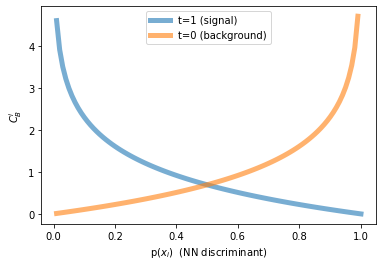

In [12]:
#plot binary cross entropy function
x= np.linspace(0.01, 1.001, 100)

fig, ax1 = plt.subplots()
ax1.plot(x, -(np.log(x)), label="t=1 (signal)",lw=5, alpha=0.6)
ax1.plot(x, -(np.log(1.0-x)), label="t=0 (background)",lw=5, alpha=0.6)

plt.xlabel("p($x_i$)  (NN discriminant)")
plt.ylabel("$C^{i}_{B}$")
plt.legend()
plt.show()

# Kaggle Higgs ML challenge

- In 2014, Kaggle (online ML community) partnered with ATLAS to stage an ML competition
- Teams were given signal ($H \rightarrow\tau \tau$) and background ($Z \rightarrow \tau \tau \;, t\bar{t} \;, W \rightarrow e/\mu$) simulation
- The best classification performance (best *Approximate Median Significance*) wins!

    # I'll use this dataset to demo various weighting ideas


In [32]:
import matplotlib
matplotlib.rcParams['font.size'] = 16
import matplotlib.pyplot as plt
import keras
import numpy as np
import os
from numpy import savetxt
from numpy import loadtxt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense  

In [33]:
%time
df = pd.read_csv("atlas-higgs-challenge-2014-v2.csv")
df

CPU times: user 41 µs, sys: 42 µs, total: 83 µs
Wall time: 3.12 ms


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.240,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.000,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.000,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.904263,b,t,6.245333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,918233,105.668,46.443,60.048,156.191,0.403,47.746,0.936,1.279,6.133,...,1.190,-0.766,41.791,0.787,-1.090,154.056,0.005721,s,u,0.259892
818234,918234,99.294,30.097,62.713,65.861,3.312,471.319,-2.611,2.294,2.889,...,1.293,-0.868,70.158,-2.018,2.893,178.856,0.000461,s,u,0.020956
818235,918235,108.497,9.837,65.149,18.006,-999.000,-999.000,-999.000,2.742,18.006,...,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.189365,b,u,53.284258
818236,918236,96.711,20.006,66.942,29.761,-999.000,-999.000,-999.000,2.479,2.739,...,1.460,2.637,-999.000,-999.000,-999.000,30.863,0.512740,b,u,22.971060


In [34]:
#extract features, labels, and weights
Labels=df['Label']

lb = preprocessing.LabelBinarizer()
labels = lb.fit_transform(Labels)
features = df.iloc[:,1:31]

X=features
y=np.ravel(labels)

print("Number of signal events = " + str(np.count_nonzero(y == 1)))
print("Number of background events = " + str(np.count_nonzero(y == 0)))

weights = df['Weight']
weights=np.ravel(weights) 

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.33, random_state=42, shuffle=True)

Number of signal events = 279560
Number of background events = 538678


# weighting strategies
- 1. **ignore weights altogether**: 
     - the relative contribution of the S and B classes to the loss function will depend on how many MC events of each class you generated!! ¯\_(ツ)_/¯
     - relative contributions of processes within mixed background class won't correspond to the SM! ¯\_(ツ)_/¯
- 2. **use $w_{final}$**
   - theoretically correct *weighted mixture* of processes
   - rare signal hardly contributes to the loss function at all! 
      - classifying $\approx$ all events as background would give $\approx$ 100% accuracy
- 3. **use $w_{final}$: but give signal events a final constant weight such that** $$\sum w^b_i = \sum w^s_i$$

In [49]:
strategy = "test"

# option 1 (ignore event weights, i.e., each event gets weight = 1.0) 
#final_weights_train = np.ones(len(weights_train)) 
#strategy = "strategy_1"

# option 2 (apply final weight to each event)
#final_weights_train = weights_train  
#strategy = "strategy_2"

# option 3 (apply final weight to each event, but give uniform weight to signal class to equalise sum of weights
#takes some manipulation!) 

df_train = pd.DataFrame()
df_train["label"] = y_train
df_train["weights"] = weights_train

sigSumWeights = np.sum(df_train[df_train["label"]==1]["weights"])
bkgSumWeights = np.sum(df_train[df_train["label"]==0]["weights"])

scale = (bkgSumWeights/sigSumWeights)
df_train.loc[df_train.label==1, "weights"] *= scale

modsigSumWeights = np.sum(df_train[df_train["label"]==1]["weights"])

print(bkgSumWeights)
print(sigSumWeights)
print(scale)
print(modsigSumWeights)

final_weights_train = df_train["weights"]
strategy = "strategy_3"

275359.81893644715
463.68266252689006
593.8540324881748
275359.8189364471


In [45]:
model = Sequential()
model.add(Dense(15, input_dim=30, activation='relu', kernel_regularizer=None))
model.add(Dense(15, activation='relu', kernel_regularizer=None))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')   
model.fit(X_train, y_train, sample_weight=final_weights_train, epochs=8, batch_size=100, verbose=1)

Epoch 1/8
548219/548219 [==============================] - 13s 23us/step - loss: 1.2029
Epoch 2/8
548219/548219 [==============================] - 12s 22us/step - loss: 0.5331
Epoch 3/8
548219/548219 [==============================] - 12s 22us/step - loss: 0.4647
Epoch 4/8
548219/548219 [==============================] - 12s 22us/step - loss: 0.4239
Epoch 5/8
548219/548219 [==============================] - 13s 23us/step - loss: 0.4097
Epoch 6/8
548219/548219 [==============================] - 12s 23us/step - loss: 0.4015 0s - loss: 0.
Epoch 7/8
548219/548219 [==============================] - 12s 23us/step - loss: 0.3923
Epoch 8/8
548219/548219 [==============================] - 12s 22us/step - loss: 0.3879


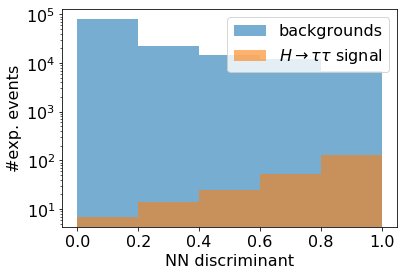

In [46]:
# plot discriminator values for "test" portion of dataset not used in training 
pred_test = model.predict(X_test)

df = pd.DataFrame()
df["labels"] = y_test
df["predictions"] = pred_test
df["weights"] = weights_test

signalVals = df[df['labels']== 1] 
backgroundVals = df[df['labels']== 0] 

plt.figure()
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")

bkgHist = plt.hist(backgroundVals["predictions"], bins=5, weights=backgroundVals["weights"],label="backgrounds", range=[0,1], alpha=0.6)
sigHist = plt.hist(signalVals["predictions"], bins=5, weights=signalVals["weights"],  label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)

plt.legend()
plt.yscale('log')
plt.show()

In [47]:
#extract signifcance vs. discriminant.
bins = sigHist[1]
nSig = sigHist[0]
nBkg = bkgHist[0]

binCentres = (bins[:-1] + bins[1:]) / 2
width = bins[1] - bins[0]
sigmas = np.array([])

for x in range(0,len(binCentres)):
    indices = [x, (len(binCentres)-1)] 
    if (nBkg[indices].sum() != 0):
        sigma = (nSig[indices].sum()) / ( np.sqrt(nBkg[indices].sum() + nBkg[indices].sum() ))
    else:
        sigma = 0.001
    sigmas = np.append(sigmas, sigma)

csvName = strategy + ".csv"
savetxt(csvName, sigmas, delimiter=',')

#now repeat for other stratgies

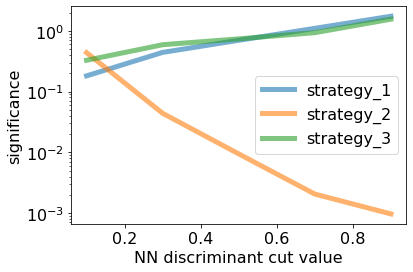

In [48]:
#make comparison plot
fig, ax1 = plt.subplots()
plt.xlabel("NN discriminant cut value")
plt.ylabel("significance")
plt.yscale('log')

strategies = ["strategy_1", "strategy_2", "strategy_3"]

for strategy in strategies:
    csvName = strategy + ".csv"
    if (os.path.isfile(csvName)):
        listSig = loadtxt(csvName, delimiter=',')
        ax1.plot(binCentres, listSig, label=strategy, lw=5, alpha=0.6)
plt.legend()    
plt.show()

# Could we do better? a few thoughts

- We care about **significance** but we minmise **binary cross entropy**...

- How about ** defining a loss function optimises the final physics result, e.g. discovery significance** $ L = 1 / (\frac{s}{(\sqrt{s+b}) + \sigma_{b}})$
  - has shownpotential when systematics are large and considered in significance [arXiv:1806.00322]
  
- Alternatively, down-weight events that contribute more to systematics [arXiv:1809.07700]